In [8]:
from tqdm import tqdm
import folium
from folium.plugins import TimestampedGeoJson
import seaborn as sns
import numpy as np
import xgboost
import pandas as pd
import os
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline
sns.set(rc={'figure.figsize':(24,8)})
DEBUG = True

def make_label(df):
    return ((df==0).sum()/(df==0).sum().max())

def time_series_feature_constructor(df):
    ans = pd.DataFrame()
    ans['max'] = df.transpose().max(axis=1)
    ans['min'] = df.transpose().min(axis=1)
    ans['mean'] = df.transpose().mean(axis=1)
    ans['last'] = df.transpose().iloc[:,-1]
    ans['median'] = df.transpose().iloc[:,df.shape[0]//2]
    return ans


# Load data
X = pd.DataFrame()
Y = pd.DataFrame()
# Read in the bikes data
data_path = 'data/'
N = len(os.listdir(data_path))
ori_df = []
groups = []
for i,f in enumerate(tqdm(os.listdir(data_path)[:])):
    # print('\r',i/N,end='')
    if 'bikes' in f and 'to' not in f and f.split(".")[-1] == 'csv':
        try:
            tmp = pd.read_csv(data_path + f,index_col=0)
            if tmp.shape[0]<600:
                continue
            tmp = tmp.sample(600).sort_index()
            tmp['time_stamp'] = f[-14:-4]+' '+tmp.index
            ori_df.append(tmp)
            groups.append(tmp.shape[0])
        except:
            print("Error in file {}".format(f))
df = pd.concat(ori_df,axis=0)

100%|██████████| 416/416 [00:01<00:00, 379.22it/s]


In [10]:
# Preview the data
df

,FENIAN_STREET,CITY_QUAY,FITZWILLIAM_SQUARE_EAST,BROOKFIELD_ROAD,EMMET_ROAD,ROTHE_ABBEY,KING_STREET_NORTH,GREEK_STREET,WESTERN_WAY,CHARLEMONT_PLACE,...,HEUSTON_BRIDGE_(NORTH),MOUNT_BROWN,CHATHAM_STREET,GRANTHAM_STREET,GRATTAN_STREET,HARDWICKE_STREET,HATCH_STREET,GOLDEN_LANE,time_stamp,CLARENDON_ROW
00:00:08,1,0,1,21,35,29,30,17,30,31,...,31,22,12.0,11,3,8,0,0,2017-01-24 00:00:08,NaN
00:02:09,1,0,1,21,35,29,30,17,30,31,...,31,22,12.0,11,3,8,0,0,2017-01-24 00:02:09,NaN
00:06:08,1,0,1,21,36,29,30,17,30,30,...,31,22,12.0,11,3,8,0,0,2017-01-24 00:06:08,NaN
00:10:08,1,0,1,22,36,29,30,17,30,31,...,31,22,12.0,11,3,8,0,0,2017-01-24 00:10:08,NaN
00:12:09,1,0,1,22,36,29,30,17,30,31,...,31,22,12.0,11,3,8,0,0,2017-01-24 00:12:09,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23:50:09,13,11,4,16,25,15,25,10,20,35,...,21,15,NaN,13,11,8,13,1,2017-08-14 23:50:09,0.0
23:52:09,13,11,4,16,27,15,25,10,20,35,...,21,15,NaN,13,11,8,13,1,2017-08-14 23:52:09,0.0
23:54:09,13,11,4,16,27,15,25,10,20,35,...,21,15,NaN,13,11,8,13,1,2017-08-14 23:54:09,0.0
23:56:08,13,11,4,16,27,15,25,10,20,35,...,21,15,NaN,13,11,8,13,1,2017-08-14 23:56:08,0.0


In [11]:
# Generate the label vector, which is the first date that each station is empty
GENERATE_Y = False
if GENERATE_Y:
    Y = {col:[pd.to_datetime(df.index[-1])] for col in df.columns}
    Y = pd.DataFrame.from_dict(Y)
    preRow = Y.iloc[-1,:]
    for i in range(df.shape[0]):
        row_id = df.shape[0] - 1 - i
        new_row = preRow
        new_row.loc[df.iloc[row_id,:]==0] = pd.to_datetime(df.index[row_id])
        Y = pd.concat([new_row.to_frame().transpose(),Y],axis=0)
    Y = Y.iloc[:-1,:]
    Y.index = df.index
    Y.to_csv('data/first_empty_date.csv')
    Y = np.argsort(Y,axis=1)
    Y.to_csv('data/label_vector.csv')
else:
    Y = pd.read_csv('data/first_empty_date.csv')

In [12]:
# Align the time stamps
Y = Y[Y['time_stamp'].isin(df['time_stamp'])]

In [13]:
# Drop columns contain NaN
df = df.dropna(axis=1)
Y = Y[df.columns]

In [79]:
import copy
class DublinBikeRecommenderDataset(object):
    """
    dataset for predicting usage of shared bikes in Dublin
    input: date/feature of each station in the previous day
    output: sorted indices of stations in the order of exhausting shared bikes 
    """
    def __init__(self,X:pd.DataFrame,Y:pd.DataFrame,groups,time_series_feature=False) -> None:
        # Preprocess the data
        # naive version: use the previous day's data as input
        pre = 0
        input = []
        output = []
        self.time_stamp = Y['time_stamp']
        Y = Y.drop(['time_stamp'],axis=1)
        new_groups = []
        for i,group_num in enumerate(groups):
            # try:
            input.append(X.iloc[pre:pre+group_num,:].reset_index().drop(['index','time_stamp'],axis=1).transpose())
            if i<len(groups)-1:
                output.append(np.argsort(Y.iloc[pre+group_num,:].transpose(),axis=0))
            else:
                output.append(np.argsort(Y.iloc[pre+group_num-1,:].transpose(),axis=0))
            new_groups.append(input[-1].shape[0])
            pre = pre+group_num
        self.vanilla_input = copy.copy(input)
        # Time series feature engineering
        if time_series_feature:
            for j in range(len(input)):
                # Make lag features
                new_input  = pd.DataFrame(index=input[j].index)
                lags = [i*25 for i in range(24)]
                for i,lag in enumerate(lags):
                    new_input['lag_'+str(i)] = input[j].shift(lag,axis=1).iloc[:,-1].values.flatten()
                windows = [i*25 for i in range(1,24)]
                for i,window in enumerate(windows):
                    new_input['window_'+str(i)] = input[j].iloc[:,window:].mean(axis=1).values.flatten()
                input[j] = new_input
        self.input = input
        self.output = output
        self.groups = new_groups
        # Split train and validation set
        # Use the last 10 days as validation set 
        self.val_input = input[-10:]
        self.val_vanilla_input = self.vanilla_input[-10:]
        self.val_output = output[-10:]
        # Make groups for ranker model
        self.groups = self.groups[:-10]
        # Here self.input and self.output are the training set
        self.input = input[:-10]
        self.output = output[:-10]
    
    def redeployment_demo(self,model,p=10):
        # Generate the redeployment plan and visualize the result for a given model
        df = []
        FRAMES_PER_DAY = 1
        for i in tqdm(range(len(self.input)-1)):
            previous_data = self.input[i]
            # Get the priority of stations
            priority_pred = np.argsort(model.predict(previous_data))
            current_data = self.input[i+1].copy()
            redeploy = current_data.iloc[:,0].copy()
            avg = int((redeploy[priority_pred[:p]].values + redeploy[priority_pred[-p:]].values).mean()/2)
            # Redeploy the bikes
            redeploy[priority_pred[:p]] = redeploy[priority_pred[-p:]] = avg
            redeploy[priority_pred[0]] += current_data.iloc[:,0].sum() - redeploy.sum()
            try:
                redeployed_data = current_data.add((redeploy - current_data.iloc[:,0]).values,axis=0)
                df.append(abs(redeployed_data.transpose().sample(FRAMES_PER_DAY)))
            except:
                print(i)
                print(current_data, )
                print(redeploy)
                assert False
        # Visualize the result
        df = pd.concat(df,axis=0).reset_index().drop('index',axis=1)
        start_timestamp = pd.Timestamp("2017-02-15 00:00:00")
        num_hours = df.shape[0]
        timestamps = pd.date_range(start=start_timestamp, periods=num_hours, freq='H')
        df['time_stamp'] = timestamps.astype(str)
        df = df.reindex(sorted(df.columns), axis=1)
        df.iloc[:,:-1] = df.iloc[:,:-1]* 12/40 + 1
        locations = pd.read_csv('station_locations.csv')
        locations['Name'] = locations['Name'].apply(lambda x : "_".join(x.split()))
        locations = locations[['Name','Latitude','Longitude']]
        locations = locations.set_index('Name')
        locations = locations.reindex(sorted(locations.columns), axis=1)
        filter_loc = locations[locations.index.isin(df.columns)]
        features = []
        for i, row in tqdm(df.iterrows(),total = df.shape[0]):
            feat = [
                {
                    "type": "Feature",
                    "geometry": {
                        "type": "Point",
                        "coordinates": filter_loc.loc[c, ['Longitude', 'Latitude']].tolist(),
                    },
                    "properties": {
                        "time": row['time_stamp'],
                        "icon": "circle",
                        "iconstyle": {
                            "fillColor": "white",
                            "fillOpacity": 0.6,
                            "stroke": "false",
                            "radius": row[c] if row[c]>1.0 else 4.0,
                            "color": "blue" if row[c]>1.0 else "red",
                        },
                        
                        # "style":{ "markerColor": "red"}
                    }} for c in filter_loc.index
            ]
            features += feat

        mp = folium.Map(location=[53.34, -6.2603], zoom_start=14,tiles='cartodbpositron')
        TimestampedGeoJson(
            {
                "type": "FeatureCollection",
                "features": features,
            },
            period="PT1H",
            duration="PT1M",
        ).add_to(mp)
        mp.save('redeployed_demo_map.html')
        return mp
    def evaluateEmptyRate(self,model,p=10):
        """
        evaluate the empty rate of the model
        """
        # Evaluate the empty rate of the model on the training set
        train_er = []
        train_original_er = []
        for i in range(len(self.input)-1):
            previous_data = self.input[i]
            priority_pred = np.argsort(model.predict(previous_data))
            current_data = self.vanilla_input[i+1].copy()
            redeploy = current_data.iloc[:,0].copy()
            avg = int((redeploy[priority_pred[:p]].values + redeploy[priority_pred[-p:]].values).mean()/2)
            redeploy[priority_pred[:p]] = redeploy[priority_pred[-p:]] = avg
            redeploy[priority_pred[0]] += current_data.iloc[:,0].sum() - redeploy.sum()
            try:
                er = (current_data.add((redeploy - current_data.iloc[:,0]).values,axis=0)==0).mean().mean()
            except:
                print(i)
                print(current_data, )
                print(redeploy)
                assert False
                
            train_er.append(er)
            train_original_er.append((current_data==0).mean().mean())
        # Evaluate the empty rate of the model on the validation set
        val_er = []
        val_original_er = []
        for i in range(len(self.val_input)-1):
            previous_data = self.val_input[i]
            priority_pred = np.argsort(model.predict(previous_data))
            current_data = self.val_vanilla_input[i+1].copy()
            redeploy = current_data.iloc[:,0].copy()
            avg = int((redeploy[priority_pred[:p]].values + redeploy[priority_pred[-p:]].values).mean()/2)
            redeploy[priority_pred[:p]] = redeploy[priority_pred[-p:]] = avg
            redeploy[priority_pred[0]] += current_data.iloc[:,0].sum() - redeploy.sum()
            er = (current_data.add((redeploy - current_data.iloc[:,0]).values,axis=0)==0).mean().mean()
            val_er.append(er)
            val_original_er.append((current_data==0).mean().mean())
        return train_er,train_original_er,val_er,val_original_er

dataset = DublinBikeRecommenderDataset(df,Y,groups)
time_series_dataset = DublinBikeRecommenderDataset(df,Y,groups,time_series_feature=True)

In [16]:
# Check if the dataset is correct
dataset.val_input[0].equals(dataset.val_input[-1])

False

In [17]:
# Display 5 rows of the validation set
dataset.val_input[-1].tail()

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
GRANTHAM_STREET,30,30,30,30,30,30,30,30,30,30,...,13,13,13,13,13,13,13,13,13,13
GRATTAN_STREET,9,9,9,9,9,9,9,9,9,9,...,11,11,11,11,11,11,11,11,11,11
HARDWICKE_STREET,4,4,4,4,4,4,4,4,4,4,...,8,8,8,8,8,8,8,8,8,8
HATCH_STREET,26,26,26,26,26,26,26,26,26,26,...,13,13,13,13,13,13,13,13,13,13
GOLDEN_LANE,14,14,14,14,14,14,14,14,14,14,...,1,1,1,1,1,1,1,1,1,1


# 2. Experimental Results

In [86]:
import warnings
warnings.filterwarnings("ignore")

In [130]:
# 1. Vanilla Models = naive_models = [xgb_model,lgb_model,cat_model]
from lightgbm import LGBMRanker
from catboost import CatBoostRanker, Pool
import xgboost
VANILLA = False
lgb_model = LGBMRanker(label_gain=[0]*100, boosting_type='gbdt', random_state=42)
xgb_model = xgboost.XGBRanker(
    tree_method='exact',
    booster='gbtree',
    objective='rank:pairwise',
    random_state=42,
    learning_rate=0.06,
    max_depth=5,
    n_estimators=700,
    subsample=0.75,
    #colsample_bytree=0.9,
    #subsample=0.75
    min_child_weight=0.06
    )
cat_model = CatBoostRanker(iterations=100, learning_rate=0.1, depth=6, loss_function='PairLogitPairwise', 
                task_type="GPU", devices='0:1', verbose=0,random_seed=42)
# if VANILLA:
train_data = pd.concat(dataset.input,axis=0).astype(float).reset_index().drop(['index'],axis=1)
train_label = pd.concat(dataset.output,axis=0).astype(float).reset_index().drop(['index'],axis=1)
# else:
#     train_data = pd.concat(time_series_dataset.input,axis=0).astype(float).reset_index().drop(['index'],axis=1)
#     train_label = pd.concat(time_series_dataset.output,axis=0).astype(float).reset_index().drop(['index'],axis=1)
xgb_model.fit(train_data, train_label,group=dataset.groups)
lgb_model.fit(train_data, train_label,group=dataset.groups)
group_id = [i//99 for i in range(sum(dataset.groups))]
train_pool = Pool(train_data, train_label,group_id=group_id)
cat_model.fit(train_pool)
naive_models = [xgb_model,lgb_model,cat_model]

In [129]:
# 2. Model with Time Series Features = time_series_models = [xgb_model,lgb_model,cat_model]
lgb_model = LGBMRanker(label_gain=[0]*100, boosting_type='gbdt', random_state=42)
xgb_model = xgboost.XGBRanker(
    tree_method='exact',
    booster='gbtree',
    objective='rank:pairwise',
    random_state=42,
    learning_rate=0.06,
    max_depth=5,
    n_estimators=700,
    subsample=0.75,
    #colsample_bytree=0.9,
    #subsample=0.75
    min_child_weight=0.06
    )
cat_model = CatBoostRanker(iterations=100, learning_rate=0.1, depth=6, loss_function='PairLogitPairwise', 
                task_type="GPU", devices='0:1', verbose=0,random_seed=42)
train_data = pd.concat(time_series_dataset.input,axis=0).astype(float).reset_index().drop(['index'],axis=1)
train_label = pd.concat(time_series_dataset.output,axis=0).astype(float).reset_index().drop(['index'],axis=1)
xgb_model.fit(train_data, train_label,group=dataset.groups)
lgb_model.fit(train_data, train_label,group=dataset.groups)
group_id = [i//99 for i in range(sum(dataset.groups))]
train_pool = Pool(train_data, train_label,group_id=group_id)
cat_model.fit(train_pool)
time_series_models = [xgb_model,lgb_model,cat_model]


XGBoost Ranker 0.07450419045527741
LightGBM Ranker 0.07905787951983605
CatBoost Ranker 0.07272443639291466


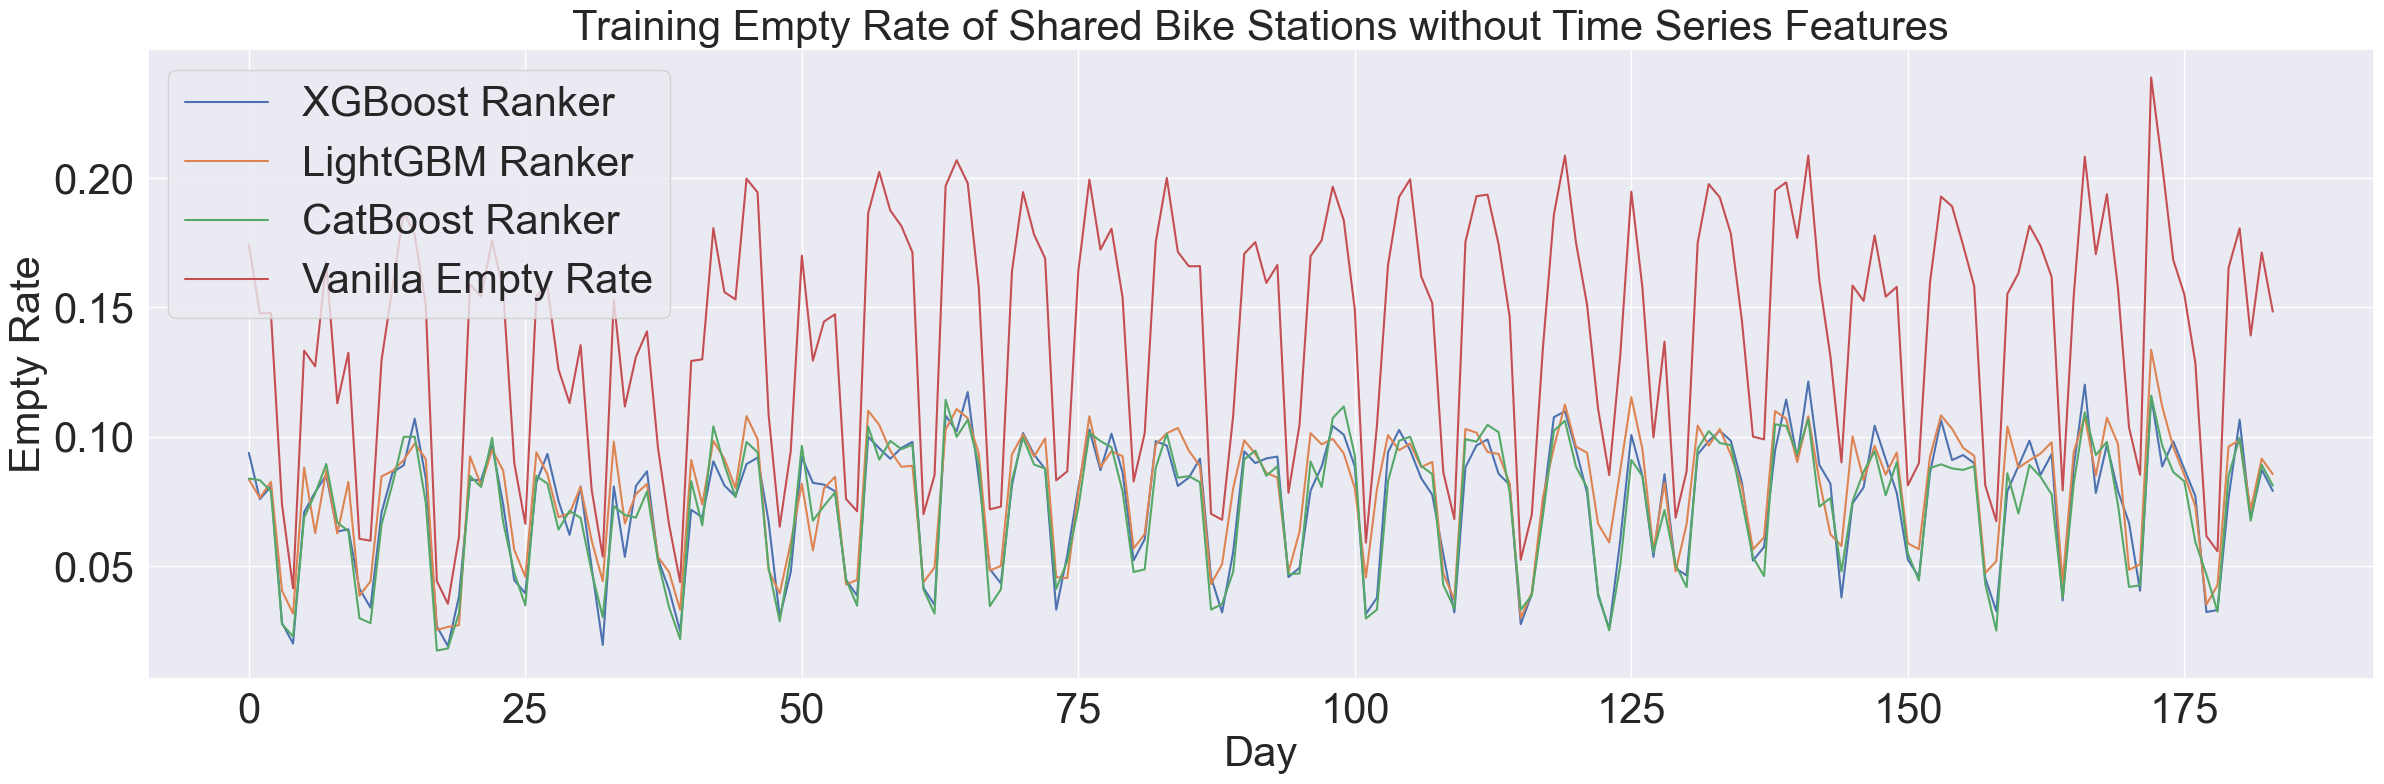

In [158]:
FONT_SIZE = 30
ps = [10,25]
labels = ['XGBoost Ranker','LightGBM Ranker','CatBoost Ranker','Vanilla Empty Rate']
# for p in ps:
for i,model in enumerate(naive_models):
    # if VANILLA:
    train_er,train_original_er,val_er,val_original_er = dataset.evaluateEmptyRate(model,p=ps[-1])
    # else:
    #     train_er,train_original_er,val_er,val_original_er = time_series_dataset.evaluateEmptyRate(model,p=10)
    sns.lineplot(data=train_er,label = labels[i],)
    print(labels[i],np.mean(train_er))
sns.lineplot(data=train_original_er,label = labels[-1])
plt.title('Training Empty Rate of Shared Bike Stations without Time Series Features',fontsize=FONT_SIZE)
plt.legend(fontsize=FONT_SIZE)
plt.xlabel('Day',fontsize=FONT_SIZE)
plt.ylabel('Empty Rate',fontsize=FONT_SIZE)
plt.xticks(fontsize=FONT_SIZE)
plt.yticks(fontsize=FONT_SIZE)
plt.tight_layout()
plt.savefig('imgs_final_report/exp1.pdf')
plt.show()

XGBoost Ranker 0.06963274044795784
LightGBM Ranker 0.07905787951983605
CatBoost Ranker 0.0716980493339189


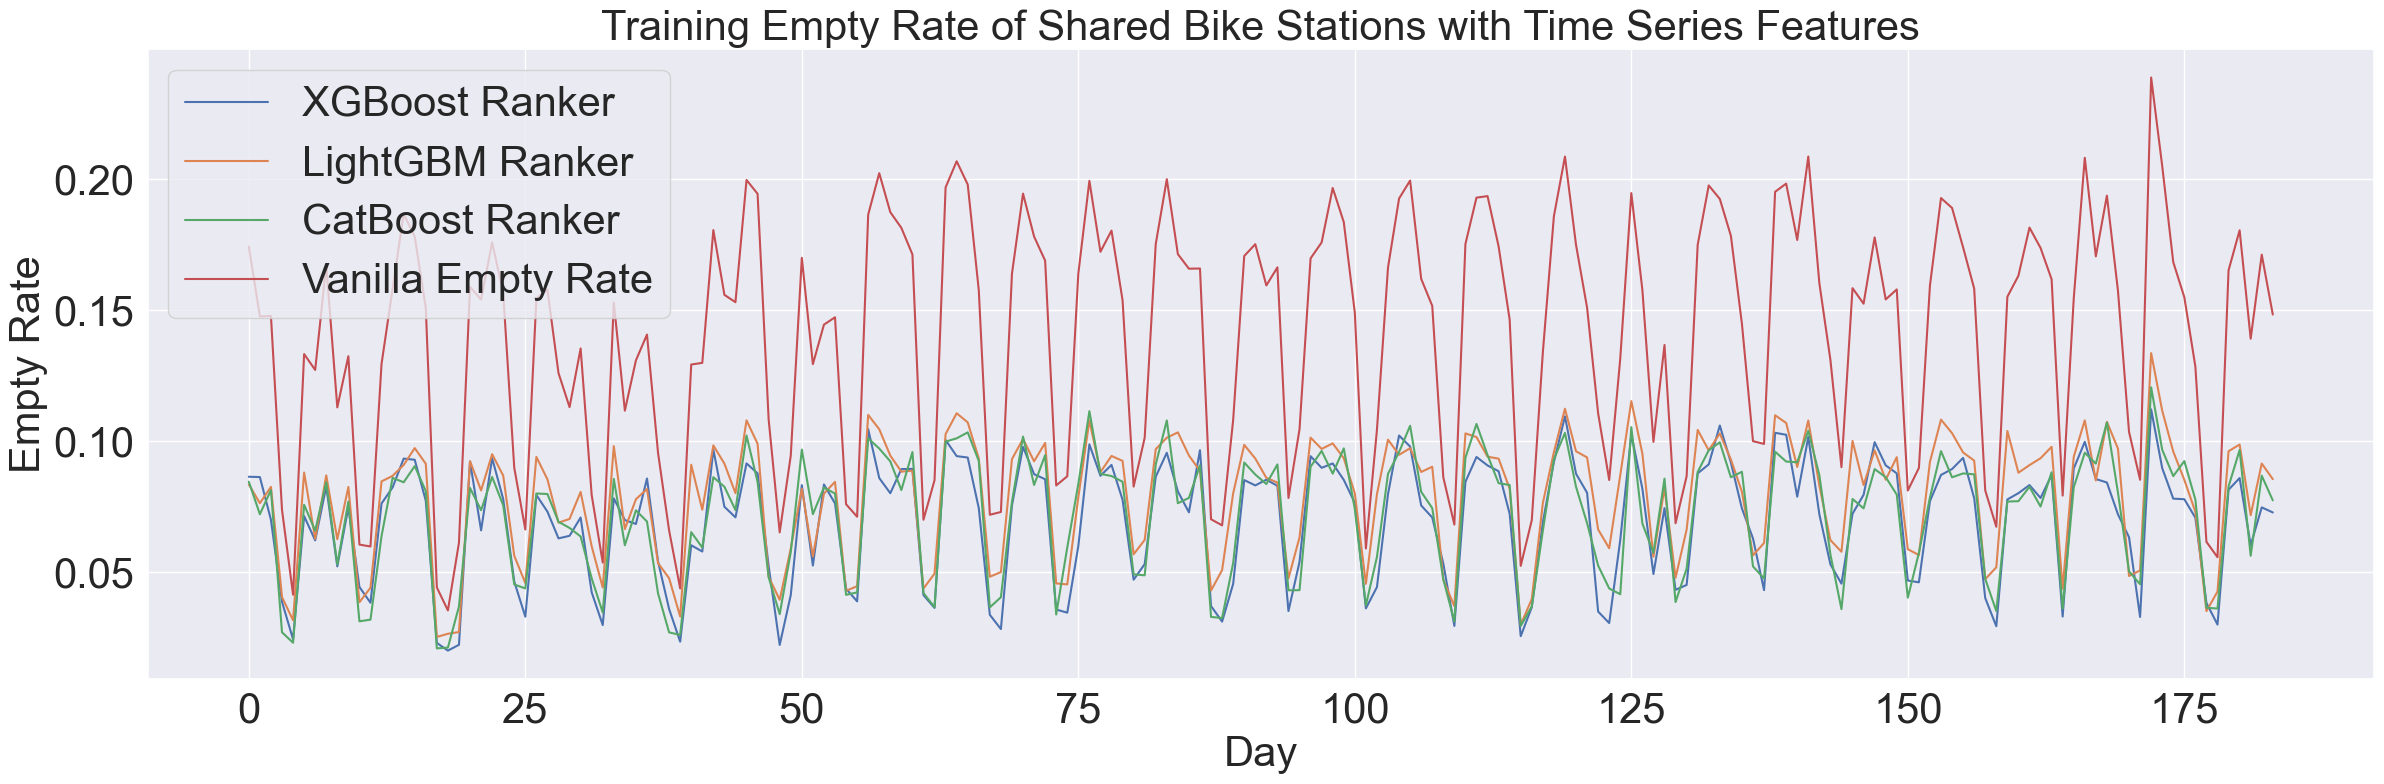

In [157]:
ps = [10,25]
# for p in ps:
labels = ['XGBoost Ranker','LightGBM Ranker','CatBoost Ranker','Vanilla Empty Rate']
for i,model in enumerate(time_series_models):
    # if VANILLA:
    # train_er,train_original_er,val_er,val_original_er = dataset.evaluateEmptyRate(model,p=10)
    # else:
    train_er,train_original_er,val_er,val_original_er = time_series_dataset.evaluateEmptyRate(model,p=ps[-1])
    sns.lineplot(data=train_er,label = labels[i])
    print(labels[i],np.mean(train_er))
sns.lineplot(data=train_original_er,label = labels[-1])

plt.title('Training Empty Rate of Shared Bike Stations with Time Series Features',fontsize=FONT_SIZE)
plt.legend(fontsize=FONT_SIZE)
plt.xlabel('Day',fontsize=FONT_SIZE)
plt.ylabel('Empty Rate',fontsize=FONT_SIZE)
plt.xticks(fontsize=FONT_SIZE)
plt.yticks(fontsize=FONT_SIZE)
plt.tight_layout()
plt.savefig('imgs_final_report/exp2.pdf')
plt.show()

In [133]:
print(np.mean(train_original_er)),print(np.mean(val_original_er))

0.1401108000292783
0.12964459408903853


(None, None)

In [135]:
ps = [10,25]
labels = ['XGBoost Ranker','LightGBM Ranker','CatBoost Ranker','Vanilla Empty Rate']
for p in ps:
    for i,model in enumerate(naive_models):
        train_er,train_original_er,val_er,val_original_er = dataset.evaluateEmptyRate(model,p=p)
        print(p,labels[i],np.mean(val_er))
for p in ps:
    for i,model in enumerate(time_series_models):
        train_er,train_original_er,val_er,val_original_er = time_series_dataset.evaluateEmptyRate(model,p=p)
        print(p,labels[i],np.mean(val_er))

10 XGBoost Ranker 0.10368686868686867
10 LightGBM Ranker 0.10724653946876168
10 CatBoost Ranker 0.10452113729891506
25 XGBoost Ranker 0.06735503179947624
25 LightGBM Ranker 0.07707818930041152
25 CatBoost Ranker 0.06767863823419379
10 XGBoost Ranker 0.10331088664421997
10 LightGBM Ranker 0.10724653946876168
10 CatBoost Ranker 0.10508043396932286
25 XGBoost Ranker 0.06730826786382342
25 LightGBM Ranker 0.07707818930041152
25 CatBoost Ranker 0.06718106995884773


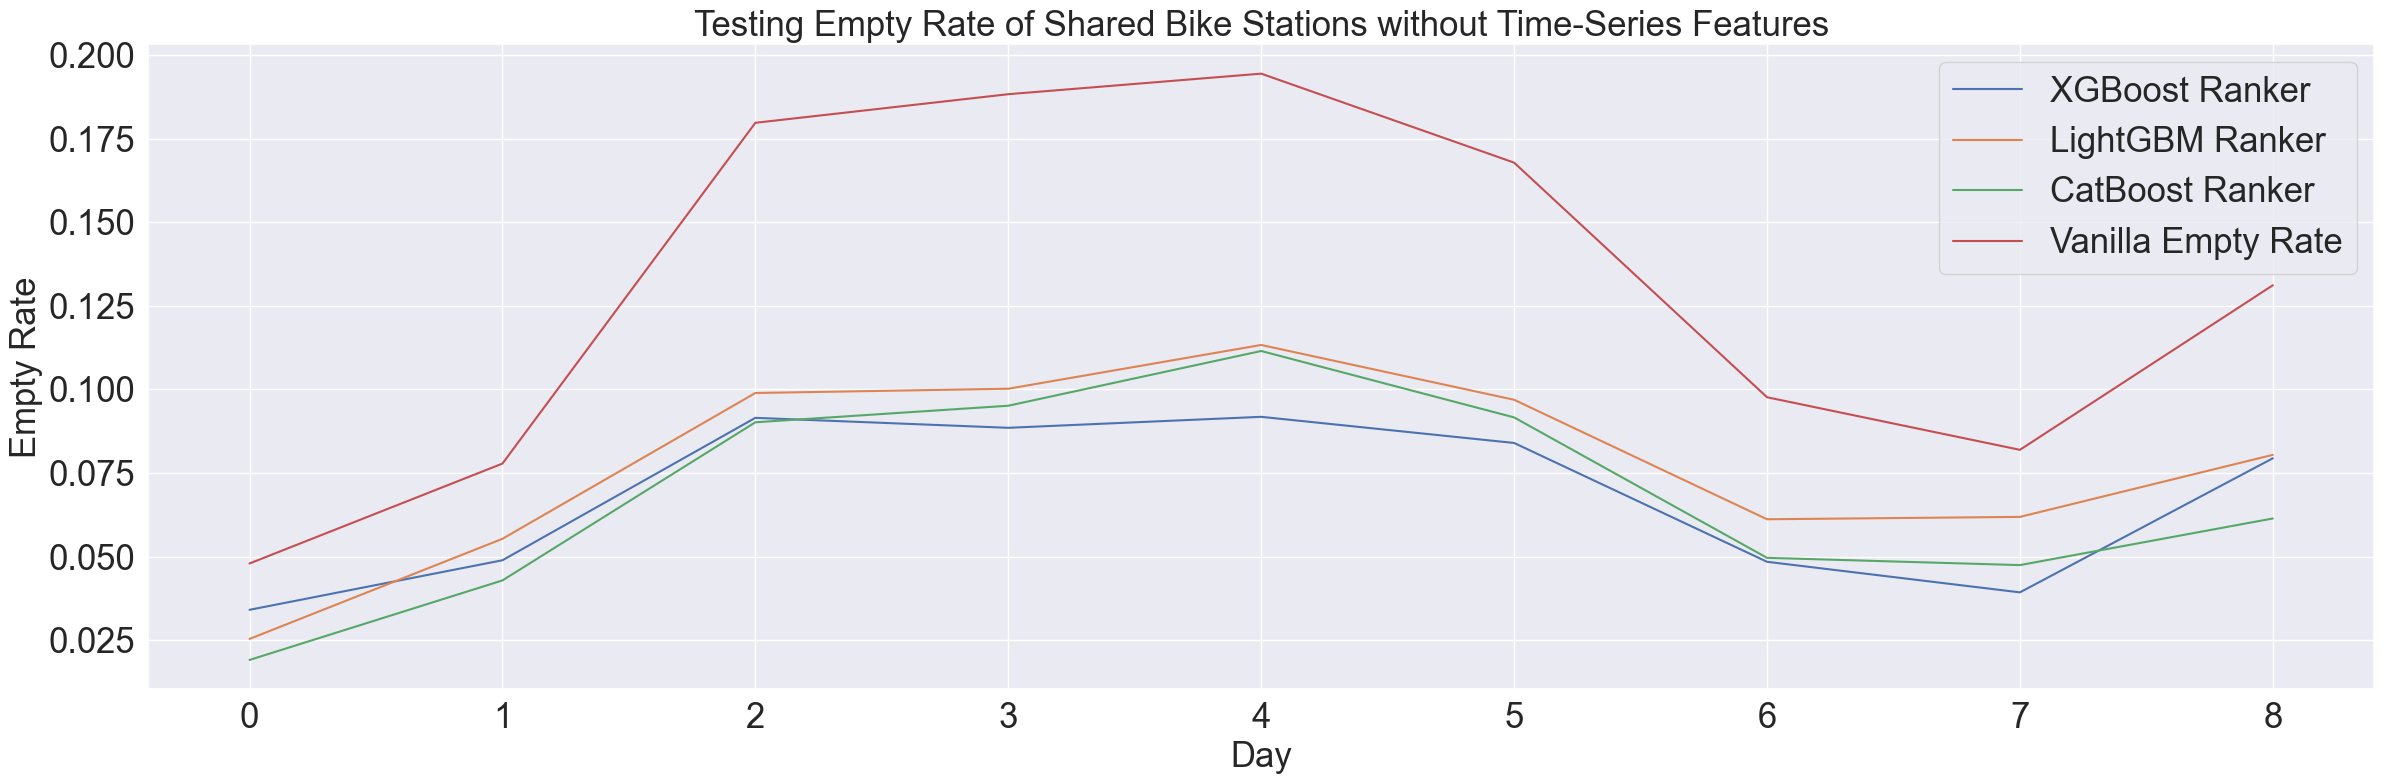

In [150]:
VANILLA = True
labels = ['XGBoost Ranker','LightGBM Ranker','CatBoost Ranker','Vanilla Empty Rate']
for i,model in enumerate(naive_models):
    if VANILLA:
        train_er,train_original_er,val_er,val_original_er = dataset.evaluateEmptyRate(model,p=ps[-1])
    else:
        train_er,train_original_er,val_er,val_original_er = time_series_dataset.evaluateEmptyRate(model,p=ps[-1])
    sns.lineplot(data=val_er,label = labels[i])
sns.lineplot(data=val_original_er,label = labels[-1])
plt.title('Testing Empty Rate of Shared Bike Stations without Time-Series Features',fontsize=FONT_SIZE)
plt.legend(fontsize=FONT_SIZE)
plt.xlabel('Day',fontsize=FONT_SIZE)
plt.ylabel('Empty Rate',fontsize=FONT_SIZE)
plt.xticks(fontsize=FONT_SIZE)
plt.yticks(fontsize=FONT_SIZE)
plt.tight_layout()
plt.savefig('imgs_final_report/exp3.pdf')

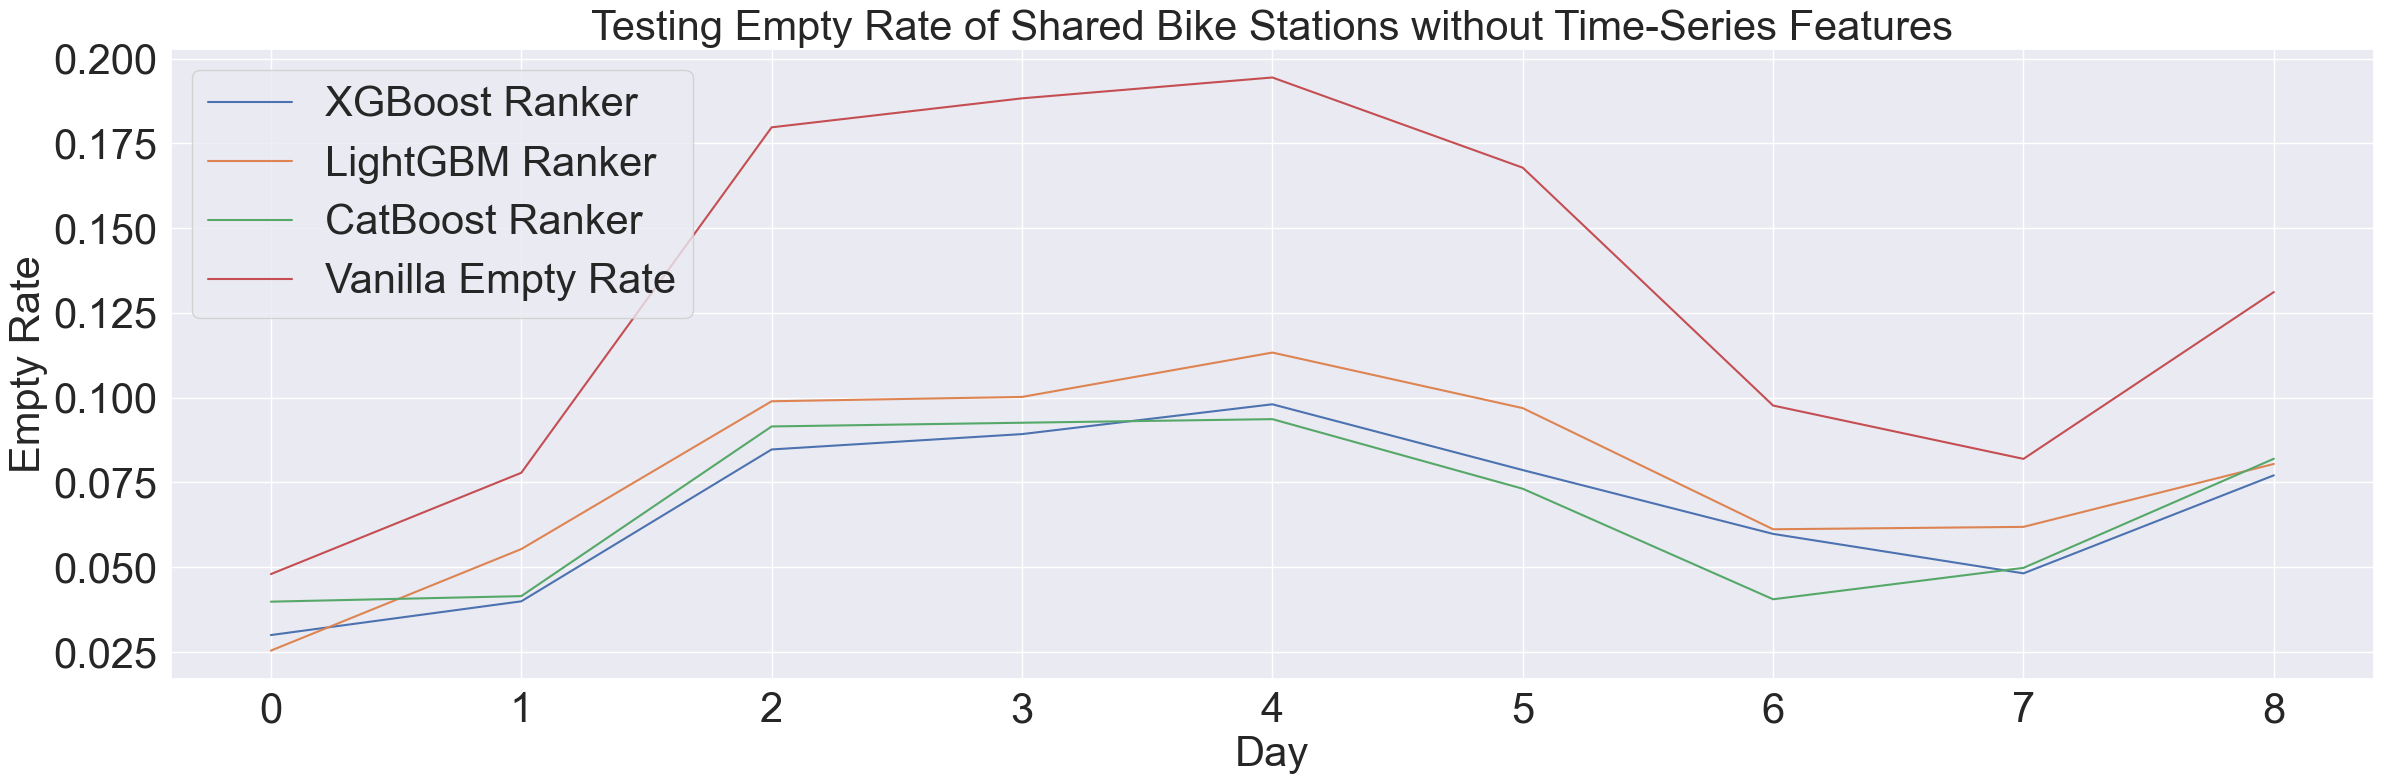

In [160]:
VANILLA = False
labels = ['XGBoost Ranker','LightGBM Ranker','CatBoost Ranker','Vanilla Empty Rate']
for i,model in enumerate(time_series_models):
    if VANILLA:
        train_er,train_original_er,val_er,val_original_er = dataset.evaluateEmptyRate(model,p=ps[-1])
    else:
        train_er,train_original_er,val_er,val_original_er = time_series_dataset.evaluateEmptyRate(model,p=ps[-1])
    sns.lineplot(data=val_er,label = labels[i])
sns.lineplot(data=val_original_er,label = labels[-1])
plt.title('Testing Empty Rate of Shared Bike Stations without Time-Series Features',fontsize=FONT_SIZE)
plt.legend(fontsize=FONT_SIZE)
plt.xlabel('Day',fontsize=FONT_SIZE)
plt.ylabel('Empty Rate',fontsize=FONT_SIZE)
plt.xticks(fontsize=FONT_SIZE)
plt.yticks(fontsize=FONT_SIZE)
plt.tight_layout()
plt.savefig('imgs_final_report/exp4.pdf')

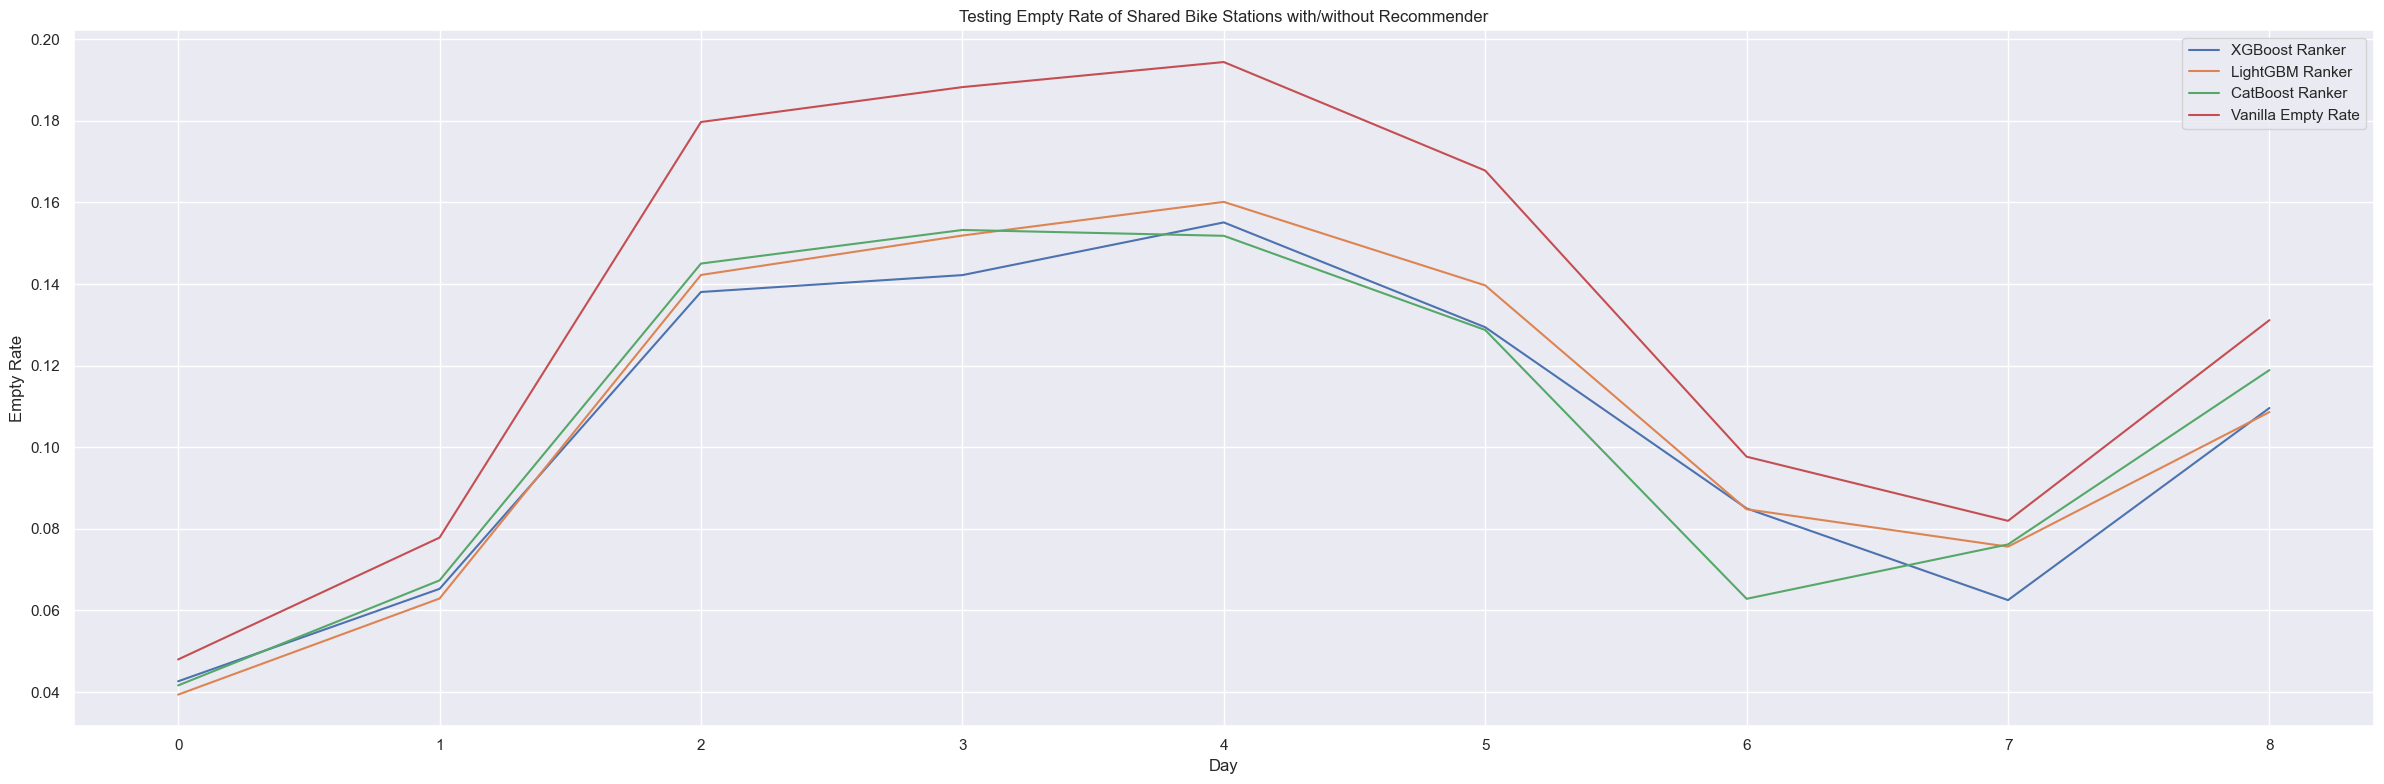

In [111]:
labels = ['XGBoost Ranker','LightGBM Ranker','CatBoost Ranker','Vanilla Empty Rate']
for i,model in enumerate(models):
    if VANILLA:
        train_er,train_original_er,val_er,val_original_er = dataset.evaluateEmptyRate(model,p=ps[-1])
    else:
        train_er,train_original_er,val_er,val_original_er = time_series_dataset.evaluateEmptyRate(model,p=ps[-1])
    sns.lineplot(data=val_er,label = labels[i])
sns.lineplot(data=val_original_er,label = labels[-1])
plt.legend()
plt.title('Testing Empty Rate of Shared Bike Stations with/without Recommender')
plt.xlabel('Day')
plt.ylabel('Empty Rate')
plt.tight_layout()
plt.savefig('imgs_final_report/exp3.pdf')

Text(0, 0.5, 'Empty Rate')

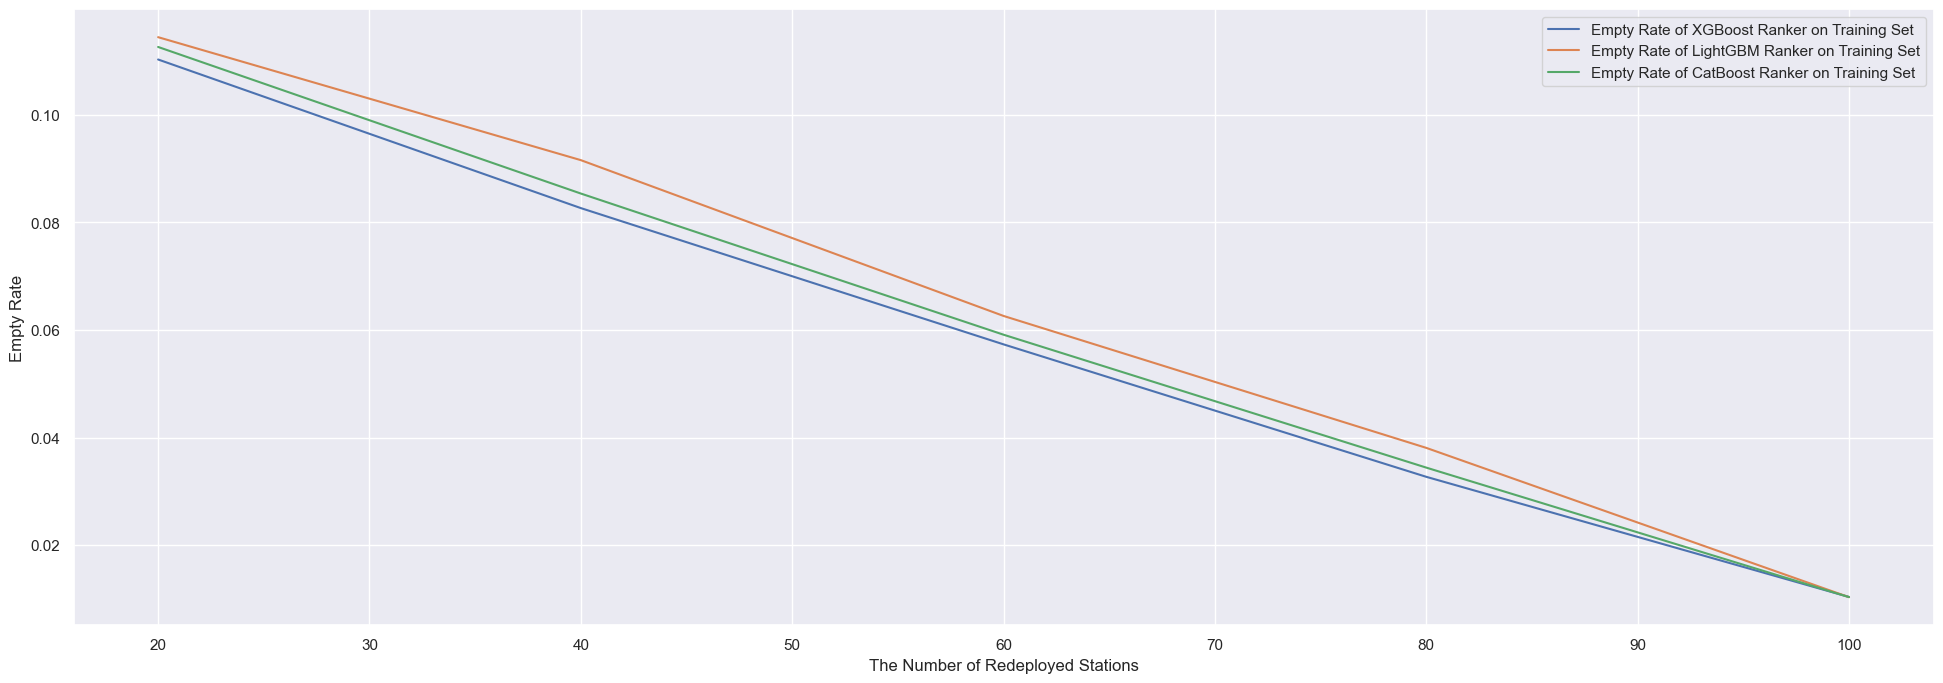

In [98]:
for i,model in enumerate(models):
    train_ers = []
    val_ers = []
    xrange = np.array(range(10,60,10))
    for p in xrange:
        if VANILLA:
            train_er,train_vanilla,val_er,val_vanilla = dataset.evaluateEmptyRate(model,p=p)
        else:
            train_er,train_vanilla,val_er,val_vanilla = time_series_dataset.evaluateEmptyRate(model,p=p)
        train_ers.append(np.mean(train_er))
        val_ers.append(np.mean(val_er))
    sns.lineplot(x=xrange*2,y=train_ers,label='Empty Rate of %s on Training Set'%labels[i])
    # sns.lineplot(x=xrange*2,y=val_ers,label='Empty Rate of %s on Validaiton Set'%labels[i])
    # train_ers = []
    # val_ers = []
    # for p in xrange:
    #     train_er,train_vanilla,val_er,val_vanilla = dataset.evaluateEmptyRate(model,p=p)
    #     train_ers.append(np.mean(train_er))
    #     val_ers.append(np.mean(val_er))
    # sns.lineplot(x=xrange*2,y=train_ers,label='Empty Rate of XGBoost on Training Set')
    # sns.lineplot(x=xrange*2,y=val_ers,label='Empty Rate of XGBoost on Validaiton Set')
plt.legend()
plt.xlabel('The Number of Redeployed Stations')
plt.ylabel('Empty Rate')